Dataset initial :
   prix_dh  surface_m2  chambres localisation    type_bien  annee_construction
0  1748357         NaN         2        Rabat  Appartement              2010.0
1  1430867       130.0         2    Marrakech        Villa              1980.0
2  1823844        99.0         3   Casablanca  Appartement              2020.0
3  2261514       126.0         4   Casablanca       Maison              1980.0
4  1382923       128.0         5        Rabat        Villa              1980.0

Dataset après nettoyage :
            prix_dh  surface_m2    chambres  annee_construction
count  1.430000e+02  135.000000  143.000000          117.000000
mean   1.466942e+06  121.703704    2.930070         2000.598291
std    4.515411e+05   31.268236    1.160684           14.281082
min    5.062150e+05   22.000000    1.000000         1980.000000
25%    1.199413e+06   98.500000    2.000000         1990.000000
50%    1.482644e+06  123.000000    3.000000         2000.000000
75%    1.742576e+06  139.000000  

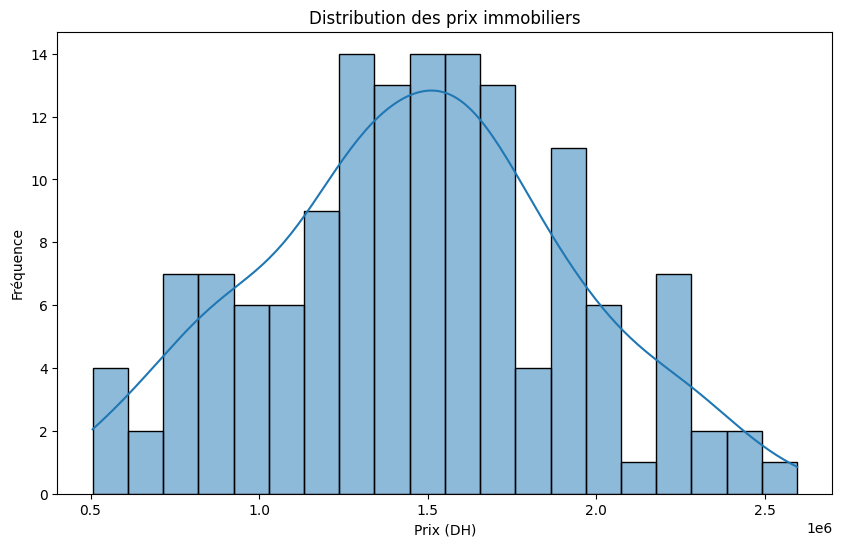

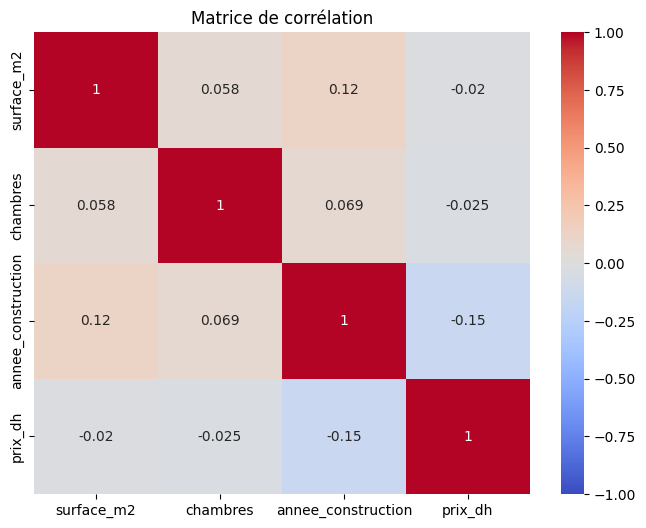

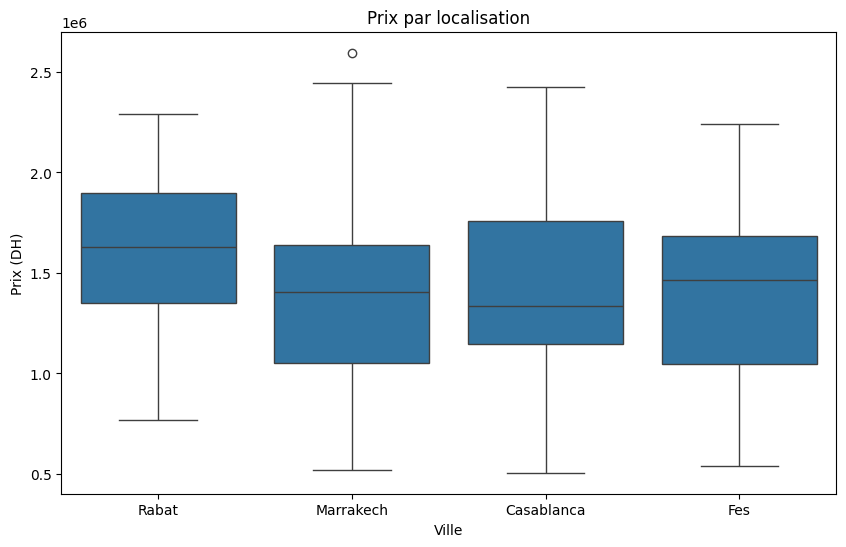

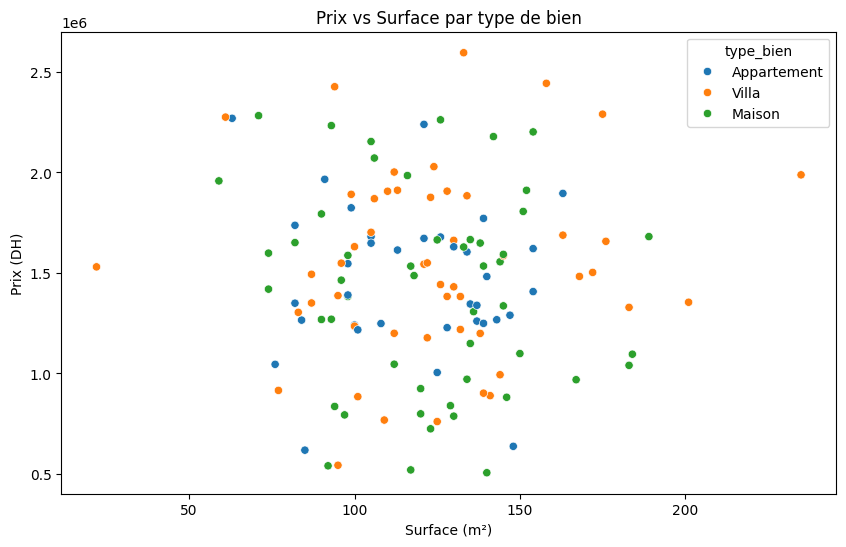


Évaluation du modèle :
R² : -0.253
RMSE : 425462.39 DH
MAE : 354053.30 DH


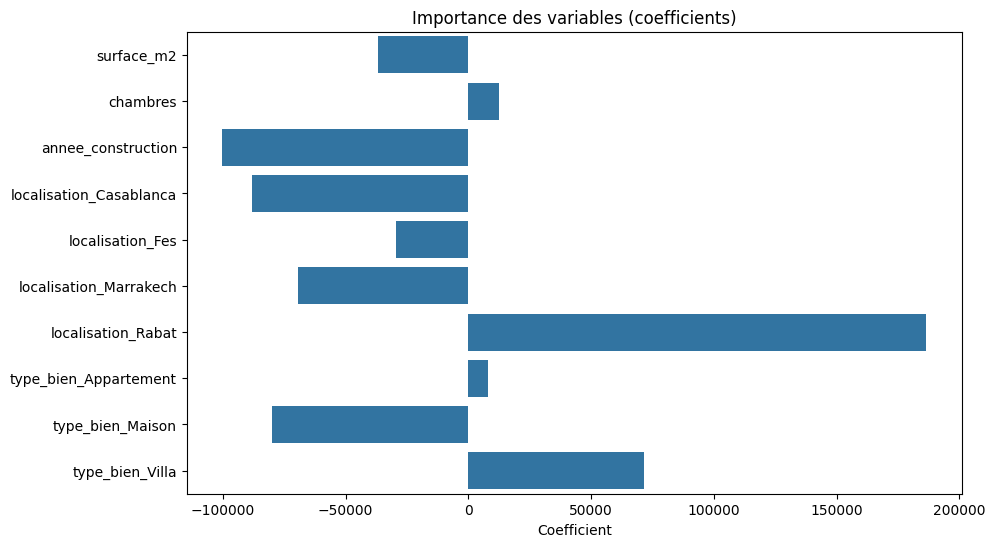

In [1]:
# Projet d'Analyse Exploratoire de Données (EDA) : Prédiction des prix immobiliers
# Script Python pour scraping (simulé), nettoyage, EDA, et modélisation
# Compatible avec Jupyter Notebook et Anaconda Navigator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Set random seed for reproducibility
np.random.seed(42)

# 1. Collecte des données (Simulé car pas d'accès à un site réel)
def create_simulated_data(n_samples=150):
    """Crée un dataset simulé d'annonces immobilières."""
    data = {
        'prix_dh': np.random.normal(1500000, 500000, n_samples).astype(int),  # Prix en DH
        'surface_m2': np.random.normal(120, 30, n_samples).astype(int),       # Surface en m²
        'chambres': np.random.choice([1, 2, 3, 4, 5], n_samples, p=[0.1, 0.3, 0.4, 0.15, 0.05]),  # Nb de chambres
        'localisation': np.random.choice(['Casablanca', 'Rabat', 'Marrakech', 'Fes'], n_samples),  # Ville
        'type_bien': np.random.choice(['Appartement', 'Maison', 'Villa'], n_samples),  # Type de bien
        'annee_construction': np.random.choice([1980, 1990, 2000, 2010, 2020, np.nan], n_samples)  # Année (avec NaN)
    }
    df = pd.DataFrame(data)
    
    # Ajouter valeurs manquantes et outliers
    df.loc[np.random.choice(df.index, 10), 'surface_m2'] = np.nan
    df.loc[np.random.choice(df.index, 5), 'prix_dh'] = df['prix_dh'] * 10
    return df

# Créer le dataset
df = create_simulated_data()
print("Dataset initial :")
print(df.head())

# 2. Nettoyage des données (Pipeline)
def build_preprocessing_pipeline():
    """Construit une pipeline de prétraitement pour les données."""
    numeric_features = ['surface_m2', 'chambres', 'annee_construction']
    categorical_features = ['localisation', 'type_bien']
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='inconnu')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    return preprocessor

def clean_data(df):
    """Nettoie les données : doublons et outliers."""
    df = df.drop_duplicates()
    
    # Gérer les outliers pour prix_dh (méthode IQR)
    Q1 = df['prix_dh'].quantile(0.25)
    Q3 = df['prix_dh'].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df['prix_dh'] >= Q1 - 1.5 * IQR) & (df['prix_dh'] <= Q3 + 1.5 * IQR)]
    return df

# Nettoyer les données
df = clean_data(df)
print("\nDataset après nettoyage :")
print(df.describe())

# 3. Analyse Exploratoire des Données (EDA)
def perform_eda(df):
    """Effectue l'analyse exploratoire des données avec visualisations."""
    # Distribution des prix
    plt.figure(figsize=(10, 6))
    sns.histplot(df['prix_dh'], bins=20, kde=True)
    plt.title("Distribution des prix immobiliers")
    plt.xlabel("Prix (DH)")
    plt.ylabel("Fréquence")
    plt.show()
    
    # Matrice de corrélation
    numeric_features = ['surface_m2', 'chambres', 'annee_construction', 'prix_dh']
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Matrice de corrélation")
    plt.show()
    
    # Prix par localisation
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='localisation', y='prix_dh', data=df)
    plt.title("Prix par localisation")
    plt.xlabel("Ville")
    plt.ylabel("Prix (DH)")
    plt.show()
    
    # Prix vs surface
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='surface_m2', y='prix_dh', hue='type_bien', data=df)
    plt.title("Prix vs Surface par type de bien")
    plt.xlabel("Surface (m²)")
    plt.ylabel("Prix (DH)")
    plt.show()

# Lancer l'EDA
perform_eda(df)

# 4. Modélisation (Régression Multiple)
def train_model(df):
    """Entraîne et évalue un modèle de régression multiple."""
    X = df.drop('prix_dh', axis=1)
    y = df['prix_dh']
    
    # Diviser les données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Pipeline complet
    model_pipeline = Pipeline(steps=[
        ('preprocessor', build_preprocessing_pipeline()),
        ('regressor', LinearRegression())
    ])
    
    # Entraîner
    model_pipeline.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model_pipeline.predict(X_test)
    
    # Évaluation
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print("\nÉvaluation du modèle :")
    print(f"R² : {r2:.3f}")
    print(f"RMSE : {rmse:.2f} DH")
    print(f"MAE : {mae:.2f} DH")
    
    # Importance des variables
    feature_names = (['surface_m2', 'chambres', 'annee_construction'] + 
                     model_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(['localisation', 'type_bien']).tolist())
    coefs = model_pipeline.named_steps['regressor'].coef_
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=coefs, y=feature_names)
    plt.title("Importance des variables (coefficients)")
    plt.xlabel("Coefficient")
    plt.show()
    
    return r2, rmse, mae

# Entraîner le modèle
r2, rmse, mae = train_model(df)